### 1. Descargar dataset

<p> Descargamos nuestro dataset de roboflow </p>

In [1]:
from roboflow import Roboflow
rf = Roboflow(api_key="DomOnOUT6ut9575GRoRT")
project = rf.workspace("riccardo-kxtut").project("overhead-person-szky0")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to overhead-Person-3 in yolov8:: 100%|██████████| 8528/8528 [00:01<00:00, 6317.02it/s]


### 2. Explorar Dataset

In [6]:
import os

# Opción 1: Ruta relativa (funciona si estás en la carpeta 'notebooks')
dataset = "overhead" 

# Opción 2: Ruta absoluta dinámica (más robusta)
# dataset = os.path.join(os.getcwd(), "overhead")

train_path = os.path.join(dataset, "train", "images")
val_path   = os.path.join(dataset, "valid", "images")
test_path  = os.path.join(dataset, "test", "images")

# Verificamos que las rutas existen antes de listar
if os.path.exists(train_path):
    num_train = len([f for f in os.listdir(train_path) if f.endswith(".jpg")])
    print(f"Entrenamiento: {num_train} imágenes")
else:
    print(f"Error: No se encontró {train_path}")

if os.path.exists(val_path):
    num_val = len([f for f in os.listdir(val_path) if f.endswith(".jpg")])
    print(f"Validación: {num_val} imágenes")
else:
    print(f"Error: No se encontró {val_path}")

if os.path.exists(test_path):
    num_test = len([f for f in os.listdir(test_path) if f.endswith(".jpg")])
    print(f"Test: {num_test} imágenes")
else:
    print(f"Error: No se encontró {test_path}")

Entrenamiento: 3708 imágenes
Validación: 413 imágenes
Test: 137 imágenes


### 3. Cantidad de etiquetas por split

In [8]:
import os
from PIL import Image

# Rutas a las imágenes
train_images = os.path.join(dataset, "train", "images")
val_images   = os.path.join(dataset, "valid", "images")
test_images  = os.path.join(dataset, "test", "images")

def summarize_image_sizes(folder, name):
    if not os.path.exists(folder):
        print(f"\n{name}: No se encontró la carpeta {folder}")
        return

    widths, heights = [], []
    for img_file in os.listdir(folder):
        if img_file.lower().endswith((".jpg", ".png", ".jpeg")):
            img_path = os.path.join(folder, img_file)
            with Image.open(img_path) as im:
                w, h = im.size
                widths.append(w)
                heights.append(h)
    
    if widths and heights:
        print(f"\n{name}:")
        print(f"  Total de imágenes: {len(widths)}")
        print(f"  Ancho: min={min(widths)}, max={max(widths)}, promedio={sum(widths)//len(widths)}")
        print(f"  Alto:  min={min(heights)}, max={max(heights)}, promedio={sum(heights)//len(heights)}")
    else:
        print(f"\n{name}: No se encontraron imágenes.")

# Ejecutar resumen
summarize_image_sizes(train_images, "Entrenamiento")
summarize_image_sizes(val_images, "Validación")
summarize_image_sizes(test_images, "Test")



Entrenamiento:
  Total de imágenes: 3708
  Ancho: min=640, max=640, promedio=640
  Alto:  min=640, max=640, promedio=640

Validación:
  Total de imágenes: 413
  Ancho: min=640, max=640, promedio=640
  Alto:  min=640, max=640, promedio=640

Test:
  Total de imágenes: 137
  Ancho: min=640, max=640, promedio=640
  Alto:  min=640, max=640, promedio=640


### 4. Balancear el dataset moviendo un 10% de las imágenes de entrenamiento a validación.

In [9]:
import os
import random
import shutil

# Ruta base del dataset
dataset_dir = "overhead"  # reemplaza con la ruta correcta si es necesario

# Rutas de imágenes y labels
train_images = os.path.join(dataset_dir, "train", "images")
train_labels = os.path.join(dataset_dir, "train", "labels")
val_images   = os.path.join(dataset_dir, "valid", "images")
val_labels   = os.path.join(dataset_dir, "valid", "labels")

# Crear carpetas de validación si no existen
os.makedirs(val_images, exist_ok=True)
os.makedirs(val_labels, exist_ok=True)

# Porcentaje de imágenes a mover a validación
val_percent = 0.1

# Listar todas las imágenes de entrenamiento
train_imgs_list = [f for f in os.listdir(train_images) if f.lower().endswith(".jpg")]

# Seleccionar aleatoriamente el 10% para validación
num_val = max(1, int(len(train_imgs_list) * val_percent))
val_imgs_selected = random.sample(train_imgs_list, num_val)

# Mover imágenes y sus etiquetas correspondientes
for img_file in val_imgs_selected:
    label_file = os.path.splitext(img_file)[0] + ".txt"
    
    # Mover imagen
    shutil.move(os.path.join(train_images, img_file),
                os.path.join(val_images, img_file))
    
    # Mover etiqueta
    src_label = os.path.join(train_labels, label_file)
    dst_label = os.path.join(val_labels, label_file)
    if os.path.exists(src_label):
        shutil.move(src_label, dst_label)

print(f"Movidas {len(val_imgs_selected)} imágenes a validación")
print(f"Nuevas cantidades:")
print("Entrenamiento:", len(os.listdir(train_images)))
print("Validación:", len(os.listdir(val_images)))


Movidas 370 imágenes a validación
Nuevas cantidades:
Entrenamiento: 3338
Validación: 783


### 5. Verificamos los cambios en las etiquetas

In [10]:
# Rutas a las etiquetas
train_labels = os.path.join(dataset, "train", "labels")
val_labels   = os.path.join(dataset, "valid", "labels")
test_labels  = os.path.join(dataset, "test", "labels")

# Verificar que las carpetas existan y contar archivos
for name, path in [("Entrenamiento", train_labels), 
                   ("Validación", val_labels), 
                   ("Test", test_labels)]:
    if os.path.exists(path):
        print(f"{name}: {len(os.listdir(path))} etiquetas")
    else:
        print(f"{name}: No se encontró la carpeta {path}")


Entrenamiento: 3338 etiquetas
Validación: 783 etiquetas
Test: 137 etiquetas


### 6. Verificar instalación y GPU

In [11]:
import torch

if torch.cuda.is_available():
    print("GPU disponible:", torch.cuda.get_device_name(0))
    print("Número de GPUs:", torch.cuda.device_count())
    print("Memoria total GPU (GB):", round(torch.cuda.get_device_properties(0).total_memory / 1e9, 2))
else:
    print("No se detectó GPU, se usará CPU")


GPU disponible: NVIDIA GeForce GTX 1650 SUPER
Número de GPUs: 1
Memoria total GPU (GB): 4.29


### 7. Cargamos modelo preentrenado - YOLOv8n

In [12]:
# Importamos ultralytics
from ultralytics import YOLO

# Cargar modelo preentrenado YOLOv8n
model = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:03<00:00, 2.11MB/s]
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


### 8. Verificamos las carpetas

In [12]:
import os

folders = [
    "overhead/train/images",
    "overhead/valid/images",
    "overhead/test/images"
]

for f in folders:
    if os.path.exists(f):
        n = len([x for x in os.listdir(f) if x.lower().endswith((".jpg", ".png", ".jpeg"))])
        print(f"{f} -> {n} imágenes")
    else:
        print(f"ERROR: Carpeta no encontrada -> {f}")


overhead/train/images -> 3338 imágenes
overhead/valid/images -> 783 imágenes
overhead/test/images -> 137 imágenes


### 9. Entrenamiento del modelo

In [2]:
from ultralytics import YOLO
import torch
import os
import gc

if __name__ == "__main__":
    # 1 Limpieza de memoria
    gc.collect()
    torch.cuda.empty_cache()

    # 2 Archivos de checkpoints
    project_dir = "runs/train/overhead_people_tracking/weights"
    last_ckpt = os.path.join(project_dir, "last.pt")
    best_ckpt = os.path.join(project_dir, "best.pt")

    # 3 Cargar modelo: prioriza last.pt, luego best.pt, si no existe usa yolov8n.pt
    if os.path.exists(last_ckpt):
        print(f"Cargando checkpoint para continuar: {last_ckpt}")
        model = YOLO(last_ckpt)
    elif os.path.exists(best_ckpt):
        print(f"Cargando mejor modelo: {best_ckpt}")
        model = YOLO(best_ckpt)
    else:
        print("No se encontró checkpoint, cargando modelo base yolov8n.pt")
        model = YOLO("yolov8n.pt")

    # 4 Verificar archivo de datos
    data_yaml = "/home/hugo/proyecto_track_people/notebooks/overhead/data.yaml"
    if not os.path.exists(data_yaml):
        data_yaml = "overhead/data.yaml"
    if not os.path.exists(data_yaml):
        print(f"Error: No se encuentra data.yaml en {data_yaml}")
        exit(1)
    print(f"Usando archivo de datos: {data_yaml}")

    # 5 Parámetros de entrenamiento
    batch_size = 4  # seguro para 4GB de VRAM
    imgsz = 640     # tamaño estándar YOLOv8
    epochs = 50     # entrenar hasta esta cantidad de epochs
    project_name = "overhead_people_tracking"

    print(f"Iniciando entrenamiento con batch={batch_size}, imgsz={imgsz} y hasta {epochs} epochs...")

    try:
        # 6 Entrenamiento
        results = model.train(
            data=data_yaml,
            epochs=epochs,
            batch=batch_size,
            imgsz=imgsz,
            project="runs/train",
            name=project_name,
            exist_ok=True,
            device=0 if torch.cuda.is_available() else 'cpu',
            verbose=True,
            workers=0,     # necesario para WSL2 o CPU limit
            amp=True,      # mixed precision para ahorrar memoria
            patience=10,   # early stopping
            resume=True    # <<--- importantísimo para continuar desde last.pt o best.pt
        )

        # 7 Exportar modelo final (best.pt)
        export_path = os.path.join("runs", "train", project_name, "weights", "best.pt")
        print(f"Modelo exportado a {export_path}")

    except Exception as e:
        print(f"Error durante el entrenamiento: {e}")
        print("Si es un error de memoria (OOM), intenta bajar imgsz a 512 o batch a 2.")


Cargando checkpoint para continuar: runs/train/overhead_people_tracking/weights/last.pt
Usando archivo de datos: /home/hugo/proyecto_track_people/notebooks/overhead/data.yaml
Iniciando entrenamiento con batch=4, imgsz=640 y hasta 50 epochs...
Ultralytics 8.3.235 🚀 Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1650 SUPER, 4096MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/hugo/proyecto_track_people/notebooks/overhead/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line

### 10. Final - rendimiendo del modelo en todas las Epocas

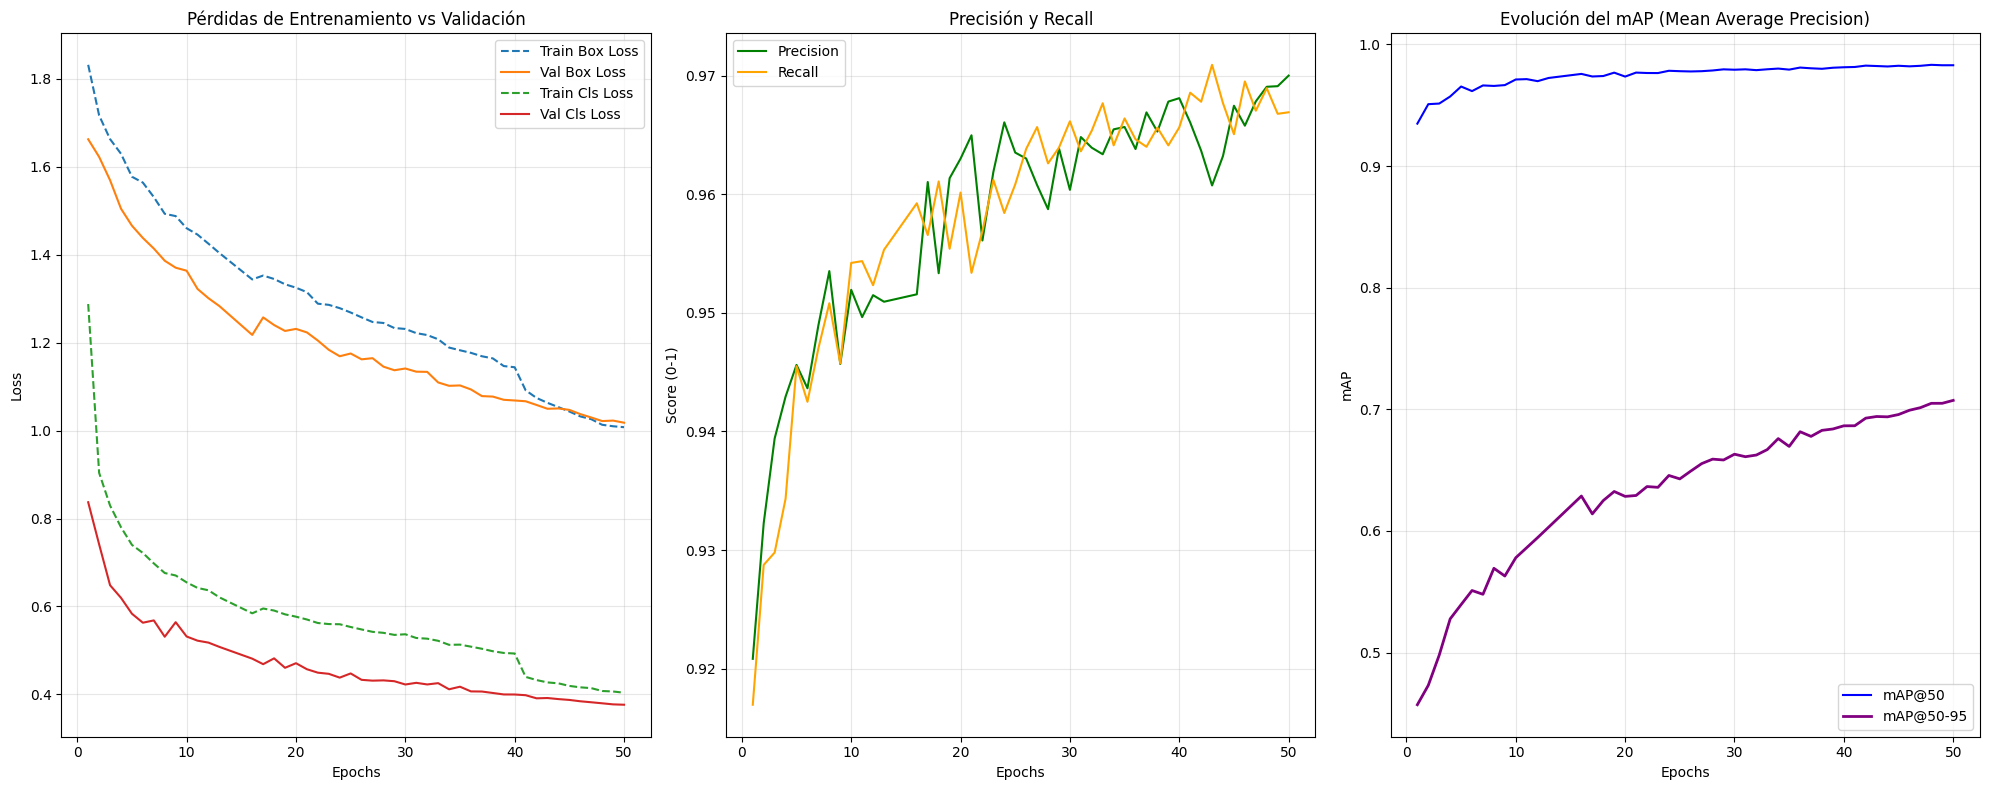

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Activar visualización en notebook
%matplotlib inline

# Ruta al archivo de resultados
results_path = '/home/hugo/proyecto_track_people/notebooks/runs/train/overhead_people_tracking/results.csv'

if os.path.exists(results_path):
    df = pd.read_csv(results_path)
    df.columns = df.columns.str.strip()
    
    plt.figure(figsize=(20, 8))
    
    # Gráfica 1
    plt.subplot(1, 3, 1)
    plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', linestyle='--')
    plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
    plt.plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss', linestyle='--')
    plt.plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss')
    plt.title('Pérdidas de Entrenamiento vs Validación')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Gráfica 2
    plt.subplot(1, 3, 2)
    plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision', color='green')
    plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall', color='orange')
    plt.title('Precisión y Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Score (0-1)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Gráfica 3
    plt.subplot(1, 3, 3)
    plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50', color='blue')
    plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95', color='purple', linewidth=2)
    plt.title('Evolución del mAP (Mean Average Precision)')
    plt.xlabel('Epochs')
    plt.ylabel('mAP')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print(f" No se encontró el archivo: {results_path}")


### 11. Descargar el mejor modelo

In [6]:
import shutil
import os

# Rutas
source_path = '/home/hugo/proyecto_track_people/notebooks/runs/train/overhead_people_tracking/weights/best.pt'
destination_dir = '/home/hugo/proyecto_track_people/models'
destination_file = os.path.join(destination_dir, 'overhead_people_tracking.pt')

# Crear carpeta models si no existe
os.makedirs(destination_dir, exist_ok=True)

# Copiar el archivo
if os.path.exists(source_path):
    shutil.copy2(source_path, destination_file)
    print(f"✅ Modelo guardado exitosamente en: {destination_file}")
else:
    print(f"❌ Error: No se encontró el modelo en {source_path}")

✅ Modelo guardado exitosamente en: /home/hugo/proyecto_track_people/models/overhead_people_tracking.pt
